# **CIS 520: Machine Learning, Fall 2020**
# **Week 5, Worksheet 3**
## **Logistic and Kernel Regression**

- **Content Creators:** Gautam Ramesh
- **Content Reviewers:** Lyle Ungar

The objective of this notebook is to help you:

* Solidify your understanding of how these models work
* Gain intuition on their strengths and weaknesses
* Learn how to run them using scikit-learn


# Setup

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits

# Helper method to find the accuracy of the class predictions

def accuracy(predicted, actual, num_samples):
  count = 0

  for i in range(num_samples):
    if predicted[i] == actual[i]:
      count += 1
  
  return count / num_samples

# Logistic Regression

Logistic regression is a modification of linear regression used to predict a class for each instance rather than a real-valued output. Instead of fitting a linear function of the features directly to our output variable, we fit it to the log-odds of the classification, which maps the range of probabilities $[0,1]$ to the real numbers.

When should you use logistic regression instead of a decision tree for a classification problem? Let's construct two different synthetic datasets to illustrate each method's strengths and weaknesses.

First, we'll randomly generate $n$ samples with $p$ features; each feature can take any value between 0 and 100. Feel free to play around with these values and see how they affect the result.

In [ ]:
n = 50000
p = 10

num_train_samples = int(n*0.8)
num_test_samples = n - num_train_samples

x = np.random.rand(n, p)*100

For our first dataset, we want all features to contribute a roughly equal amount independently. We'll use a threshold to turn this into a two-class classification problem.

In [ ]:
def f1(row):
  num = 0
  for i in range(p):
    num += row[i] ** 0.5
    
  return num > (50 ** 0.5) * p

y1 = np.apply_along_axis(f1, 1, x)

For our second dataset, we want there to be a lot of interaction between the features, so we use a multiplicative function.

In [ ]:
def f2(row):
  num = 1
  for i in range(p):
    num *= row[i] ** (1/p)

  return num > 50

y2 = np.apply_along_axis(f2, 1, x)

You can play around with these functions to see how our two algorithms perform on various types of data. Now, we'll use the first $\frac{4n}{5}$ samples to train both a decision tree and logistic regression on the two datasets. Then, we'll test each model on the remaining $\frac{n}{5}$ samples.

In [ ]:
# Construct train and test data

x_train = x[:num_train_samples]
x_test = x[num_train_samples:]

y1_train = y1[:num_train_samples]
y1_test = y1[num_train_samples:]

y2_train = y2[:num_train_samples]
y2_test = y2[num_train_samples:]

# Use logistic regression to train a classifier for each dataset

logistic_classifier = LogisticRegression(random_state = 0)

y1_logistic_predict = logistic_classifier.fit(x, y1).predict(x_test)
y2_logistic_predict = logistic_classifier.fit(x, y1).predict(x_test)

# Do the same using decision trees

tree_classifier = tree.DecisionTreeClassifier(max_depth = 10)

y1_tree_predict = tree_classifier.fit(x, y1).predict(x_test)
y2_tree_predict = tree_classifier.fit(x, y2).predict(x_test)

# Predict classes for each data set using the learned classifiers and print their accuracies

y1_logistic_accuracy = accuracy(y1_logistic_predict, y1_test, num_test_samples)
y2_logistic_accuracy = accuracy(y2_logistic_predict, y2_test, num_test_samples)

y1_tree_accuracy = accuracy(y1_tree_predict, y1_test, num_test_samples)
y2_tree_accuracy = accuracy(y2_tree_predict, y2_test, num_test_samples)

print("Logistic regression accuracy for dataset 1: " + str(y1_logistic_accuracy))
print("Decision tree accuracy for dataset 1: " + str(y1_tree_accuracy))
print()
print("Logistic regression accuracy for dataset 2: " + str(y2_logistic_accuracy))
print("Decision tree accuracy for dataset 2: " + str(y2_tree_accuracy))

Logistic regression accuracy for dataset 1: 0.9475
Decision tree accuracy for dataset 1: 0.895

Logistic regression accuracy for dataset 2: 0.8489
Decision tree accuracy for dataset 2: 0.9243


Which method (logistic regression or decision trees) works best on which data set? Why?

Note: Although we can sometimes judge beforehand which technique will be more suited to the problem at hand, it's often best to try them all out and pick the one that does best--or to use a method (which we haven't seen yet) that combines the best of both.

# Kernel Regression

We can think of kernel regression as an improved version of k-Nearest Neighbors: instead of simply taking the most represented class among the nearest neighbors, we consider an average weighted by a function of the distance. To illustrate this, we'll compare the performance of kernel regression with that of KNN on MNIST, a famous dataset of handwritten digits.



In [ ]:
dt = load_digits()

First, let's train and test KNN classifiers on the data set with a few different values of $k$. We'll use the first $\frac{6}{10}$ of the dataset to train our model, and the remaining instances to test.

Max k: 3
Max accuracy: 0.9680111265646731


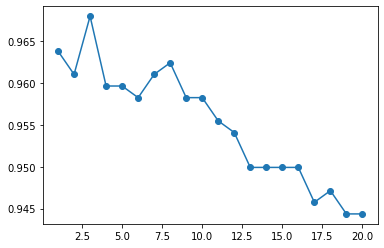

In [ ]:
n = len(dt.data)
num_train_samples = int(6*n/10)
num_test_samples = n - num_train_samples

x_train = dt.data[:num_train_samples]
x_test = dt.data[num_train_samples:]

y_train = dt.target[:num_train_samples]
y_test = dt.target[num_train_samples:]

k_values = list(range(1,21))
accs = []

max_acc = 0
max_k = None

for k in range(1,21):
  nbrs = KNeighborsClassifier(n_neighbors=k)
  acc = accuracy(nbrs.fit(x_train, y_train).predict(x_test), y_test, num_test_samples)
  accs.append(acc)

  if acc > max_acc:
    max_acc = acc
    max_k = k
  
print("Max k: " + str(max_k))
print("Max accuracy: " + str(max_acc))

plt.scatter(k_values, accs)
plt.plot(k_values, accs)
plt.show()

Notice that the accuracy goes down with larger values of $k$. This is because we start to allow more and more distant training instances to influence our classification of each test instance. Kernel regression counteracts this issue by assigning smaller weights to training instances that are further away from the test instance at hand. Let's see how it does for differnet values of the smoothing parameter $\sigma$:

Max sigma: 6.75
Max accuracy: 0.9694019471488178


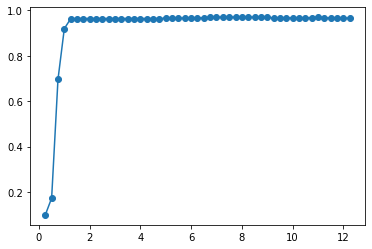

In [ ]:
# Implement Gaussian kernel
def kernel(sigma):
  return lambda distances: np.exp(-1*(distances ** 2) / (sigma ** 2))

sigma_values = []
accs = []

max_accuracy = 0
max_sigma = None

for i in range(1, 50):
  val = i / 4
  sigma_values.append(val)

  # Use all 120 "neighbors", but weight them by the kernel of the distance
  y_predict = KNeighborsClassifier(n_neighbors=num_train_samples, weights=kernel(val)).fit(x_train, y_train).predict(x_test)
                                                                                                                     
  acc = accuracy(y_predict, y_test, num_test_samples)
  accs.append(acc)

  if acc > max_accuracy:
    max_accuracy = acc
    max_sigma = val

print("Max sigma: " + str(max_sigma))
print("Max accuracy: " + str(max_accuracy))

plt.scatter(sigma_values, accs)
plt.plot(sigma_values, accs)
plt.show()

You should find that kernel regression performs better than KNN for any value of $k$.

For what sorts of data would k-NN be better than kernel regression?